In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/FYP Dataset/Final Dataset for FYP.zip'

# Destination directory
output_dir = '/content/drive/My Drive/dataset/'

# Unzipping
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Files extracted to {output_dir}")


Files extracted to /content/drive/My Drive/dataset/


In [ ]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split

# Paths
zip_file_path = '/content/drive/MyDrive/FYP Dataset/Final Dataset for FYP.zip'  # Path to the zip file
all_images_dir = '/content/dataset/all_images/Final Dataset for FYP'  # Root directory containing all subfolders
train_dir = '/content/newdataset/train'  # Path for training set
test_dir = '/content/newdataset/test'  # Path for testing set

# Step 1: Unzip the dataset (if not already done)
print("Unzipping the dataset...")
os.makedirs('/content/dataset/all_images', exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/all_images')
print("Dataset unzipped successfully!")

# Step 2: Get list of all image files with their labels (subfolder names)
print("Collecting image files...")
image_paths = []
labels = []

for root, dirs, files in os.walk(all_images_dir):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            full_path = os.path.join(root, file)
            label = os.path.basename(root)  # Use the immediate parent folder as label
            image_paths.append(full_path)
            labels.append(label)

# Debug: Check if images are found
if not image_paths:
    print("No images found in the specified directory. Check the directory structure and file extensions.")
    raise ValueError(f"No images found in {all_images_dir}.")

print(f"Total images found: {len(image_paths)}")

# Step 3: Split the data (80% train, 20% test) while keeping labels
print("Splitting the data into training and testing sets...")
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Step 4: Create subfolders for train and test sets
print("Organizing data into train and test subfolders...")
for subset, paths, labels_set in [('train', train_paths, train_labels), ('test', test_paths, test_labels)]:
    subset_dir = train_dir if subset == 'train' else test_dir
    os.makedirs(subset_dir, exist_ok=True)

    for img_path, label in zip(paths, labels_set):
        label_dir = os.path.join(subset_dir, label)
        os.makedirs(label_dir, exist_ok=True)  # Ensure label subfolder exists

        shutil.copy(img_path, os.path.join(label_dir, os.path.basename(img_path)))  # Copy image to subfolder

print("Data split completed successfully!")
print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")


Unzipping the dataset...
Dataset unzipped successfully!
Total images found: 982
Splitting the data into training and testing sets...
Organizing data into train and test subfolders...
Data split completed successfully!
Training images: 785
Testing images: 197


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, DenseNet169
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# ================================
# 1. Set Random Seeds for Reproducibility
# ================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ================================
# 2. Define Constants and Paths
# ================================
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Smaller batch size for better generalization
NUM_CLASSES = 5
EPOCHS = 50
INITIAL_LR = 1e-4  # Reduced initial learning rate to avoid large initial loss
TRAIN_DIR = '/content/newdataset/train'
VALID_DIR = '/content/newdataset/test'
DRIVE_MODEL_PATH = '/content/model_checkpoints/new_models'

# Ensure the directory exists for saving outputs
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# ================================
# 3. Create Data Generators with Augmentation
# ================================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = datagen_val.flow_from_directory(
    VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 4. Build a Simplified Multi-Branch Model with Moderate Regularization
# ================================

def build_model():
    inputs = Input(shape=INPUT_SHAPE, name="main_input")

    # Instantiate only two base models to reduce complexity
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, pooling='avg', name='resnet_base')
    densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='avg', name='densenet_base')

    # Pass the input through each model independently
    resnet_out = resnet_base(inputs)
    densenet_out = densenet_base(inputs)

    # Concatenate the outputs of the models
    combined = Concatenate(name='concatenate')([resnet_out, densenet_out])

    # Add fully connected layers with reduced L2 regularization and dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(combined)
    x = Dropout(0.5, name='dropout1')(x)  # Moderate dropout rate
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    # Define inputs and outputs in the final model
    model = Model(inputs=inputs, outputs=output, name='RegularizedMultiBranchModel')
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# 5. Training with Early Stopping and Learning Rate Reduction
# ================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

# ================================
# Plot Training and Validation Accuracy and Loss
# ================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# ================================
# Save the Model Weights
# ================================
model.sav(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.weights.keras'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')

Found 785 images belonging to 5 classes.
Found 197 images belonging to 5 classes.
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.4688 - loss: 7.4683 - val_accuracy: 0.7868 - val_loss: 5.7774 - learning_rate: 1.0000e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 33s 314ms/step - accuracy: 0.6833 - loss: 5.8768 - val_accuracy: 0.8223 - val_loss: 5.0575 - learning_rate: 1.0000e-04
Epoch 3/50
65/99 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.7735 - loss: 5.0752

In [ ]:
!unzip -u /content/ih.zip -d /content/dataset

Archive:  /content/ih.zip
   creating: /content/dataset/Final Dataset for FYP/
   creating: /content/dataset/Final Dataset for FYP/Normal/
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0814.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0815.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0816.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0817.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0818.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0819.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0820.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0821.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0822.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0823.JPG  
  inflating: /content/dataset/Final Dataset for FYP/Normal/IMG_E0824.JPG  
  inflating: /content/dataset/Final 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset path
dataset_path = "/content/dataset/Final Dataset for FYP"  # Original dataset path
output_dir = "./split_dataset1"  # Output folder for train, val, test
os.makedirs(output_dir, exist_ok=True)

# Create new folders for train, val, test
for folder in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, folder), exist_ok=True)

# Get all classes
classes = os.listdir(dataset_path)
classes = [cls for cls in classes if os.path.isdir(os.path.join(dataset_path, cls))]

# Split the dataset and copy files
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    images = [img for img in images if os.path.isfile(os.path.join(class_path, img))]

    # Skip classes with no images
    if not images:
        print(f"Skipping empty class folder: {cls}")
        continue

    # Split into train, val, test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=1/3, random_state=42)

    # Define target paths
    for subset, subset_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        subset_dir = os.path.join(output_dir, subset, cls)
        os.makedirs(subset_dir, exist_ok=True)

        # Copy files
        for img in subset_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(subset_dir, img)
            shutil.copy2(src, dst)

# Summary
print(f"Dataset successfully split into folders:")
print(f"Train folder: {os.path.join(output_dir, 'train')}")
print(f"Validation folder: {os.path.join(output_dir, 'val')}")
print(f"Test folder: {os.path.join(output_dir, 'test')}")


Dataset successfully split into folders:
Train folder: ./split_dataset1/train
Validation folder: ./split_dataset1/val
Test folder: ./split_dataset1/test


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_66 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,281,029 (512.24 MB)

 Trainable params: 134,281,029 (512.24 MB)

 Non-trainable params: 0 (0.00 B)

Found 761 images belonging to 5 classes.
Found 218 images belonging to 5 classes.
Found 111 images belonging to 5 classes.
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3461 - loss: 1.5451 - val_accuracy: 0.3349 - val_loss: 1.4089
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3736 - loss: 1.3928 - val_accuracy: 0.3578 - val_loss: 1.2975
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4608 - loss: 1.1934 - val_accuracy: 0.6147 - val_loss: 0.9781
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6190 - loss: 1.0117 - val_accuracy: 0.6514 - val_loss: 0.9425
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6579 - loss: 0.9278 - val_accuracy: 0.6927 - val_loss: 0.9749
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6934 - loss: 0.8564 - val_accuracy: 0.6881 - val_loss: 0.8760
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 993ms/step - accuracy: 0.7437 - loss: 0.7713 - val_accuracy: 0.7110 - val_loss: 0.8181
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7550 - loss: 0.7376 - val_accuracy: 0.6284 - val_loss: 0.9294


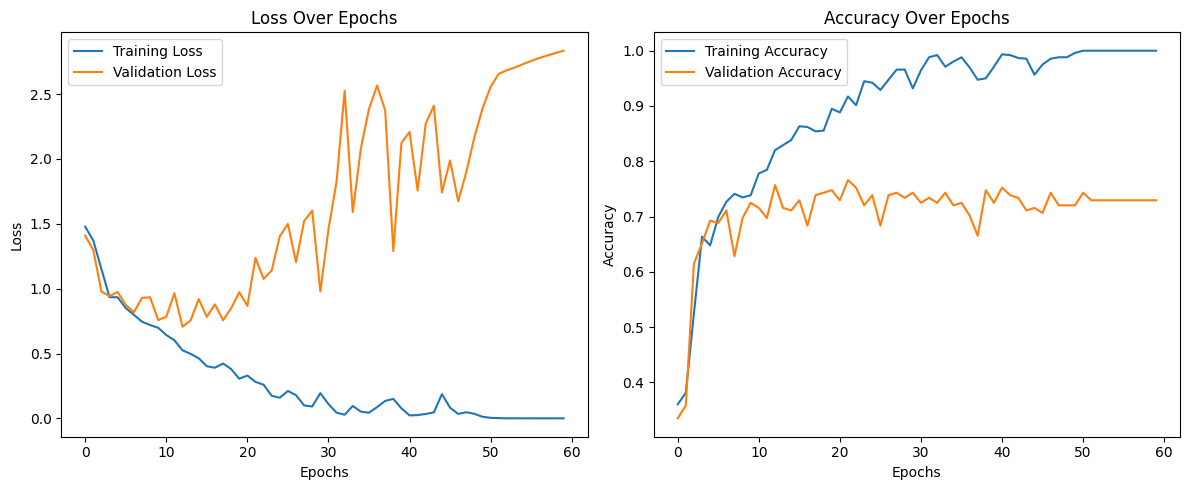

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step

Performance on Test Data
Precision: 0.7493636493636494
Recall: 0.7567567567567568
F1 Score: 0.7500733263383865
Accuracy: 0.7567567567567568
Confusion Matrix:
          Normal  Patches  Stage 1  Stage 2  Stage 3
Normal       14        0        0        0        0
Patches       0        2        2        1        1
Stage 1       1        0       34        2        4
Stage 2       3        2        0        6        2
Stage 3       0        0        6        3       28


In [ ]:
  import os
  import random
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import tensorflow as tf
  from tensorflow.keras import layers
  from tensorflow.keras.models import Model, Sequential
  from tensorflow.keras.layers import (
      Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add,
      GlobalAveragePooling2D, Flatten, Dense
  )
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.applications import VGG16
  from tensorflow.keras.optimizers import Adam
  from sklearn.model_selection import KFold
  from sklearn.metrics import (
      accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
  )

  # Directory for the dataset
  data_dir = "/content/split_dataset1"

  # Define the CNN architecture

  # Create a new sequential model
  model = Sequential()
  # Block 1
  model.add(Conv2D(64, (3, 3), activation='swish', padding='same', input_shape=(224, 224, 3)))
  model.add(Conv2D(64, (3, 3), activation='swish', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Block 2
  model.add(Conv2D(128, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='swish', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Block 3
  model.add(Conv2D(256, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(256, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(256, (3, 3), activation='swish', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Block 4
  model.add(Conv2D(512, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(512, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(512, (3, 3), activation='swish', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Block 5
  model.add(Conv2D(512, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(512, (3, 3), activation='swish', padding='same'))
  model.add(Conv2D(512, (3, 3), activation='swish', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # Fully connected layers
  model.add(Flatten())
  model.add(Dense(4096, activation='swish'))
  model.add(Dense(4096, activation='swish'))
  model.add(Dense(5, activation='softmax'))

  # Print the model summary
  model.summary()
  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


  # ImageDataGenerators
  train_datagen = ImageDataGenerator(rescale=1./255)
  val_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Data generators for training, validation, and testing
  train_generator = train_datagen.flow_from_directory(
      os.path.join(data_dir, 'train'),
      target_size=(224, 224),
      batch_size=32,
      class_mode='sparse',
      shuffle=True
  )

  val_generator = val_datagen.flow_from_directory(
      os.path.join(data_dir, 'val'),
      target_size=(224, 224),
      batch_size=32,
      class_mode='sparse',
      shuffle=False
  )

  test_generator = test_datagen.flow_from_directory(
      os.path.join(data_dir, 'test'),
      target_size=(224, 224),
      batch_size=32,
      class_mode='sparse',
      shuffle=False
  )

  # Training the model
  history = model.fit(train_generator, epochs=60, validation_data=val_generator)

  # Plot training results
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Helper function to evaluate the model on given test generator
  def evaluate_model(test_generator, model, classes, title="Performance"):
      y_test_pred = model.predict(test_generator)
      y_test_pred = np.argmax(y_test_pred, axis=1)

      precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
      recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
      f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
      accuracy = accuracy_score(test_generator.labels, y_test_pred)

      print(f"\n{title}")
      print("Precision:", precision)
      print("Recall:", recall)
      print("F1 Score:", f1)
      print("Accuracy:", accuracy)

      # Display the confusion matrix
      confusion = confusion_matrix(test_generator.labels, y_test_pred)
      confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
      print("Confusion Matrix:\n", confusion_df)

  # Test the model on the test set
  evaluate_model(test_generator, model, ['Normal', 'Patches', 'Stage 1', 'Stage 2', 'Stage 3'], title="Performance on Test Data")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_132"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_79[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_82[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Found 761 images belonging to 5 classes.
Found 218 images belonging to 5 classes.
Found 111 images belonging to 5 classes.
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1261 - loss: 2.2701 - val_accuracy: 0.3578 - val_loss: 1.5883
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 824ms/step - accuracy: 0.3716 - loss: 1.5058 - val_accuracy: 0.4587 - val_loss: 1.3452
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 784ms/step - accuracy: 0.5121 - loss: 1.2743 - val_accuracy: 0.5780 - val_loss: 1.1827
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - accuracy: 0.5850 - loss: 1.1100 - val_accuracy: 0.6147 - val_loss: 1.0603
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 834ms/step - accuracy: 0.6369 - loss: 0.9697 - val_accuracy: 0.6606 - val_loss: 0.9697
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 821ms/step - accuracy: 0.6755 - loss: 0.9096 - val_accuracy: 0.6789 - val_loss: 0.8980
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 763ms/step - accuracy: 0.6933 - loss: 0.8403 - val_accuracy: 0.6927 - val_loss: 0.8340
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 917ms/step - accuracy: 0.7093 - loss: 0.7731 - val_accuracy: 0.7248 -

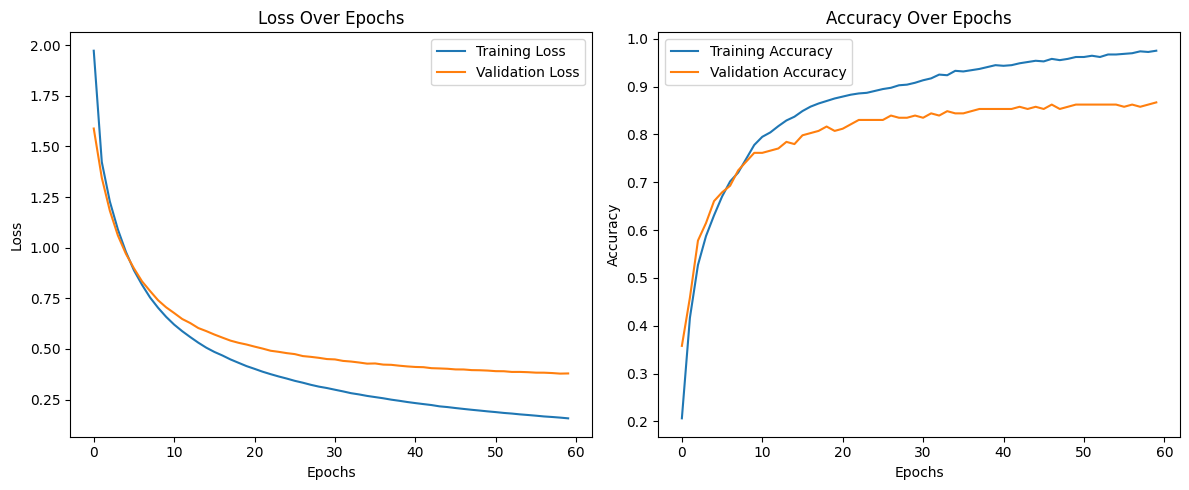

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step

Performance on Test Data
Precision: 0.9082689832689833
Recall: 0.9009009009009009
F1 Score: 0.9027081766545368
Accuracy: 0.9009009009009009
Confusion Matrix:
          Normal  Patches  Stage 1  Stage 2  Stage 3
Normal       12        0        2        0        0
Patches       0        5        1        0        0
Stage 1       3        0       37        1        0
Stage 2       0        0        0       12        1
Stage 3       0        0        0        3       34


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Directory for the dataset
data_dir = "/content/split_dataset1"

# InceptionV3 Model with custom classification head
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add custom layers on top of the InceptionV3 base
model = Model(inputs=base_model.input,
              outputs=layers.Dense(5, activation='softmax')(GlobalAveragePooling2D()(base_model.output)))

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=60, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on the test set
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['Normal', 'Patches', 'Stage 1', 'Stage 2', 'Stage 3'], title="Performance on Test Data")


Found 761 images belonging to 5 classes.
Found 111 images belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - accuracy: 0.4158 - loss: 7.5308 - val_accuracy: 0.8108 - val_loss: 5.8171 - learning_rate: 1.0000e-04
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 383ms/step - accuracy: 0.7493 - loss: 5.8301 - val_accuracy: 0.8919 - val_loss: 5.0103 - learning_rate: 1.0000e-04
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - accuracy: 0.7806 - loss: 5.1375 - val_accuracy: 0.9099 - val_loss: 4.5026 - learning_rate: 1.0000e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 387ms/step - accuracy: 0.8414 - loss: 4.5687 - val_accuracy: 0.9279 - val_loss: 4.1430 - learning_rate: 1.0000e-04
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 378ms/step - accuracy: 0.8538 - loss: 4.2408 - val_accuracy: 0.8468 - val_loss: 4.1417 - learning_rate: 1.0000e-04
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 397ms/step - accuracy: 0.8769 - loss: 4.0645 - val_accuracy: 0.8919 - val_loss: 3.8556 - learning_rate: 1.0000e-04
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - accuracy: 0.9082

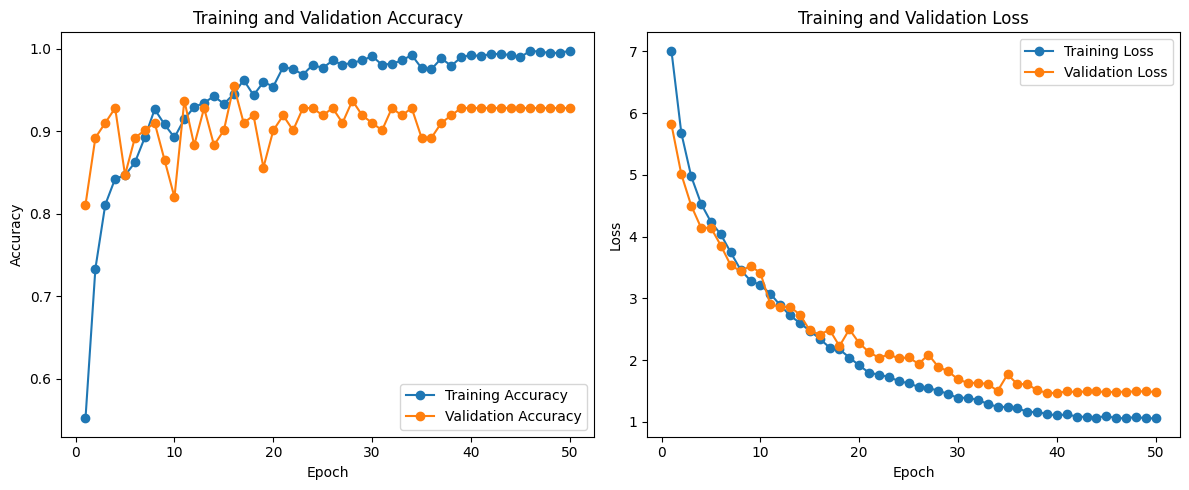

Saved model weights to /content/drive/MyDrive/model_checkpoints/new_models/final_model_weights.weights.h5


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, DenseNet169
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# ================================
# 1. Set Random Seeds for Reproducibility
# ================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ================================
# 2. Define Constants and Paths
# ================================
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Smaller batch size for better generalization
NUM_CLASSES = 5
EPOCHS = 50
INITIAL_LR = 1e-4  # Reduced initial learning rate to avoid large initial loss
TRAIN_DIR = '/content/split_dataset1/train'
VALID_DIR = '/content/split_dataset1/test'
DRIVE_MODEL_PATH = '/content/drive/MyDrive/model_checkpoints/new_models'

# Ensure the directory exists for saving outputs
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# ================================
# 3. Create Data Generators with Augmentation
# ================================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = datagen_val.flow_from_directory(
    VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 4. Build a Simplified Multi-Branch Model with Moderate Regularization
# ================================

def build_model():
    inputs = Input(shape=INPUT_SHAPE, name="main_input")

    # Instantiate only two base models to reduce complexity
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, pooling='avg', name='resnet_base')
    densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='avg', name='densenet_base')

    # Pass the input through each model independently
    resnet_out = resnet_base(inputs)
    densenet_out = densenet_base(inputs)

    # Concatenate the outputs of the models
    combined = Concatenate(name='concatenate')([resnet_out, densenet_out])

    # Add fully connected layers with reduced L2 regularization and dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(combined)
    x = Dropout(0.5, name='dropout1')(x)  # Moderate dropout rate
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    # Define inputs and outputs in the final model
    model = Model(inputs=inputs, outputs=output, name='RegularizedMultiBranchModel')
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# 5. Training with Early Stopping and Learning Rate Reduction
# ================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

# ================================
# Plot Training and Validation Accuracy and Loss
# ================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# ================================
# Save the Model Weights
# ================================
model.save(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.weights.keras'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')

In [ ]:
# ================================
# Save the Model Weights
# ================================
DRIVE_MODEL_PATH = '/content/'
model.save(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.keras'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')

Saved model weights to /content/final_model_weights.weights.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.82      1.00      0.90        14
     Patches       1.00      1.00      1.00         6
     Stage 1       1.00      0.90      0.95        41
     Stage 2       0.79      0.85      0.81        13
     Stage 3       0.95      0.95      0.95        37

    accuracy                           0.93       111
   macro avg       0.91      0.94      0.92       111
weighted avg       0.93      0.93      0.93       111



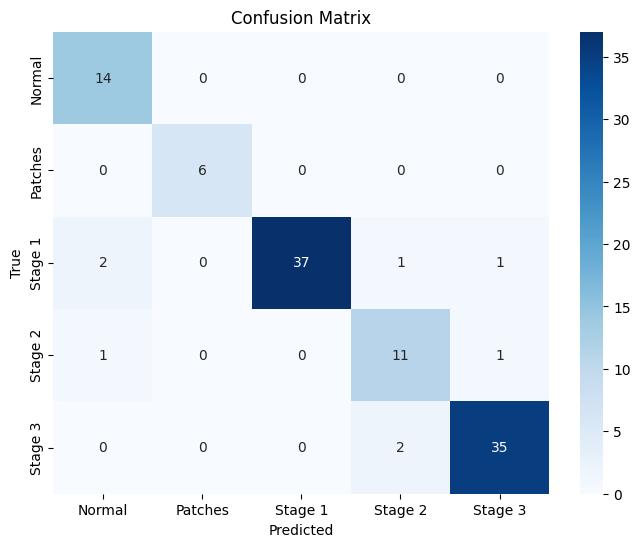

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ================================
# 1. Get Predictions on Validation Set
# ================================
# Predict the labels on the validation set
y_pred = model.predict(valid_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability

# Get true labels
y_true = valid_generator.classes  # True labels for the validation set

# ================================
# 2. Classification Report
# ================================
# Generate classification report
class_names = list(valid_generator.class_indices.keys())  # Class names from the generator
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# ================================
# 3. Confusion Matrix
# ================================
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
